<a href="https://colab.research.google.com/github/francomanca93/fundamentos-practicos-de-machine-learning/blob/main/3.decision-tree/decision_trees_sklearn_clasificador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comprendiendo nuestro data set para la creación de un árbol de decisión

Titanic, lista de pasajeros que se encontraron en este con diferentes caracteristicas. El objetivo es saber si el pasajero  puedo o no sobrevivir. 

Se trabajar con un archivo previamente procesado para enfocarnos en el algoritmo en si.

Tiene variedad de datos y algo de complejidad al trabajar con ellos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set()

In [2]:
# Read data
train_df = pd.read_csv('/content/titanic-train.csv')

# Ignore test.csv because it does not have labels for the target prediction 
# test_df = pd.read_csv('/content/titanic-test.csv')

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


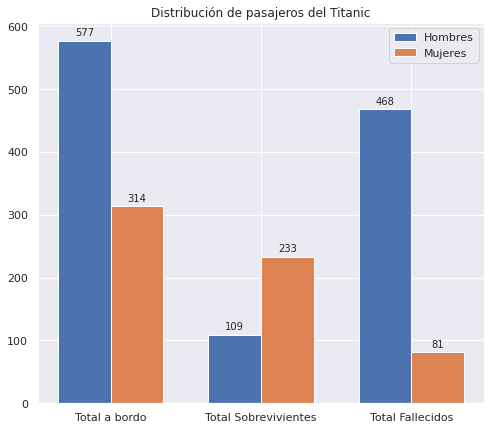

In [4]:
labels = ['Total a bordo', 'Total Sobrevivientes','Total Fallecidos']
hombres_vivos = [train_df.Sex.value_counts()[0],train_df[(train_df.Survived == 1)].Sex.value_counts()[1],train_df[(train_df.Survived == 0)].Sex.value_counts()[0]]
mujeres_vivas = [train_df.Sex.value_counts()[1],train_df[(train_df.Survived == 1)].Sex.value_counts()[0],train_df[(train_df.Survived == 0)].Sex.value_counts()[1]]

x = np.arange(len(labels)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(8,7))  # Localización de las etiquetas
rects1 = ax.bar(x - width/2, hombres_vivos, width, label='Hombres')
rects2 = ax.bar(x + width/2, mujeres_vivas, width, label='Mujeres')

# Agregue texto para etiquetas, títulos y etiquetas personalizadas del eje x, etc.
ax.set_title('Distribución de pasajeros del Titanic')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
  '''Adjunta una etiqueta de texto sobre cada barra recta, mostrando su altura.'''
  for rect in rects:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # Desplazamiento vertical de 3 puntos
                textcoords="offset points",
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

# Tratamiento de datos

In [5]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

encoder_sex = label_encoder.fit_transform(train_df['Sex'])
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Completaremos los valores nulos de Age (con la media de edades) y Embarked (con ‘S’; embarcados en Southampton)

In [6]:
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())
train_df['Embarked'] = train_df['Embarked'].fillna('S')

Eliminamos la columnas que no consideramos necesarias


In [7]:
titanic_data = train_df.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
#axis=1 se refiere a las columnas (axis=0 → filas)

Separamos las columnas categóricas de las numéricas:

- Para detectar la columnas categóricas analizamos la columna con dtype (debe ser igual a ‘object’), consideramos además que no haya mas de 10 diferentes valores (como factor de seguridad)


In [8]:
categorical_cols = [cname for cname in titanic_data.columns if
                    titanic_data[cname].nunique() < 10 and
                    titanic_data[cname].dtype == 'object'
                    ]
categorical_cols

['Sex', 'Embarked']

- Para detectar la columnas numéricas analizamos la columna con dtype (debe ser igual a 'int64' o 'float64')

In [9]:
numerical_cols = [cname for cname in titanic_data.columns if
                  titanic_data[cname].dtype in ['int64', 'float64']
                  ]
numerical_cols

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

- Unimos nuevamente las columnas en una sola variable pero con los datos numéricos separados de los categóricos

In [10]:
my_cols = categorical_cols + numerical_cols

titanic_data = titanic_data[my_cols]
titanic_data.head()

,Sex,Embarked,Pclass,Age,SibSp,Parch,Fare
0,male,S,3,22.0,1,0,7.2500
1,female,C,1,38.0,1,0,71.2833
2,female,S,3,26.0,0,0,7.9250
3,female,S,1,35.0,1,0,53.1000
4,male,S,3,35.0,0,0,8.0500


- Usamos el método **get_dummies** para codificar las variables categoricas.

> Variable indicadora, **dummy**, ficticia o binaria
> 
> La palabra indicadora, dummy, ficticia o binaria es la denominación genérica para una variable que toma valores de 0 o de 1 y que se utiliza para re-expresar variables cualitativas.


In [12]:
dummy_encoded_titanic_data = pd.get_dummies(titanic_data)
dummy_encoded_titanic_data.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


In [13]:
train_df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

Ahora tenemos nuestra data sin valores vacíos y codificada, lista para entrenar nuestro algoritmo

# Entrenamiento del modelo de clasificación

In [14]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Generamos nuestras variables de entrenamiento

In [15]:
y_target = train_df['Survived'].values
x_features_one = dummy_encoded_titanic_data.values

Podemos dividir los datos en entrenamiento y test con train_test_split pero tenemos un csv con datos de test, usaremos estos datos (previamente tratados al igual que los datos de entrenamiento)

In [16]:
x_train , x_test, y_train , y_test =  train_test_split(x_features_one, y_target, test_size= .25, random_state=1)

# Defino modelo

In [17]:
tree_one = tree.DecisionTreeClassifier()
tree_one = tree_one.fit(x_train,y_train)

# Evaluo el modelo

In [18]:
tree_one_accuracy = round(tree_one.score(x_test,y_test), 4)
print('Accuracy: %0.4f' %(tree_one_accuracy))

Accuracy: 0.7534


# Visualización del árbol de decisión

Exporto arbol de decision completo

In [19]:
from io import StringIO 
from IPython.display import Image, display
import pydotplus

out = StringIO()
tree.export_graphviz(tree_one, out_file = out)

graph = pydotplus.graph_from_dot_data(out.getvalue())
graph.write_png('titanic.png')

True

Viendo el arbol de decision con una profundidad maxima de 3, para poder visualizar las primeras ramas.

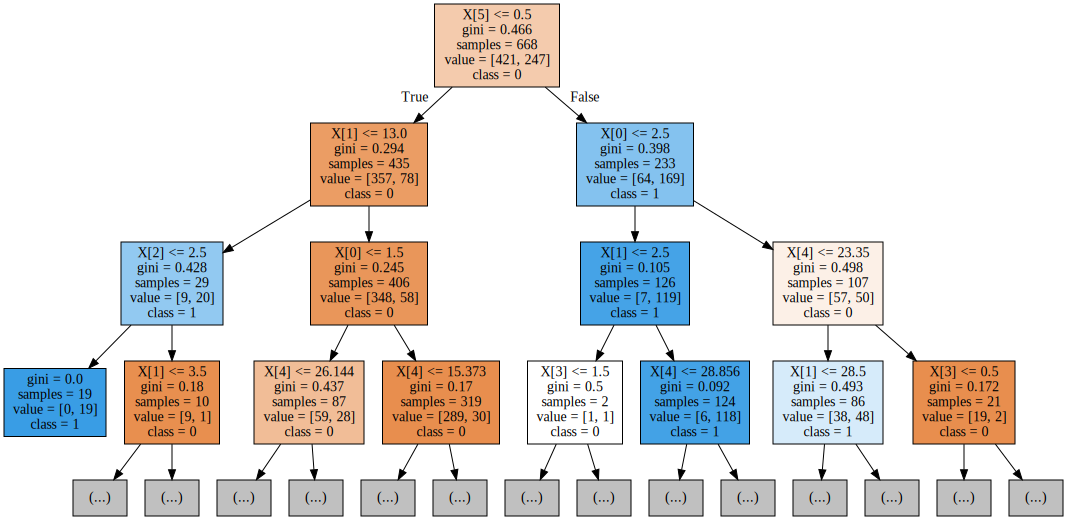

In [22]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

graph = Source(tree.export_graphviz(tree_one, out_file=None,
                                    class_names=['0', '1', '2'] ,
                                    filled = True,
                                    max_depth = 3))
display(SVG(graph.pipe(format='svg')))